# Audrey's Background Subtraction Checking Notebook

In [2]:
## OBJECTIVE 1: Import our class functions and verify installation

## First import general packages for running python analysis:
import os
import numpy as np
from matplotlib.pyplot import *
import h5py
import datetime
import pytz

## Then import the beamcals module packages and initialize 'gbosite' class:
from beamcals import corr
from beamcals import concat
from beamcals import drone
from beamcals import bicolog
import beamcals.plotting_utils as pu
import beamcals.fitting_utils as fu
import beamcals.geometry_utils as gu
import beamcals.time_utils as tu
from beamcals.sites import site
gbosite=site.site('/home/erk26/newburghlabdrone/beamcals/beamcals/sites/GBO_config.npz')

Steps:
1. Import telescope and drone data, concat the two (following tutorial)
2. Remove pulses, check by eye that on/off/span points are tagged correctly
3. Background subtract data
4. Zoom into pieces of the flight, check that passes appear smooth
5. If needed, tinker with pieces of remove source pulses code and repeat steps 2-4
    - Will suggested changing sign in "self.t_delta_pulse=np.nanmedian(Pr_max_t_0_per_channel)+(self.tstep*0.5) # 1/2 integration period" line... i think... 
6. Does uncertainty from points impact gaussian fitting? how much? 

# August Flights

In [4]:
flightdict826 = {'FLY521':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T133606Z_yale_drone/corr/20210826T133618Z/', 
                 'FLY522':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T141003Z_yale_drone/corr/20210826T141017Z/', 
                 'FLY523':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T143504Z_yale_drone/corr/20210826T143516Z/', 
                 'FLY524':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T145839Z_yale_drone/corr/20210826T145851Z/',
                 'FLY525':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T151953Z_yale_drone/corr/20210826T152004Z/',
                 'FLY526':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T162023Z_yale_drone/corr/20210826T162036Z/',
                 'FLY527':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T170313Z_yale_drone/corr/20210826T170324Z/',
                 'FLY533':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T182904Z_yale_drone/corr/20210826T182915Z/',
                 'FLY534':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T185621Z_yale_drone/corr/20210826T185632Z/',
                 'FLY535':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T192056Z_yale_drone/corr/20210826T192108Z/',
                 'FLY536':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T195003Z_yale_drone/corr/20210826T195014Z/'}

flightdict826 = {'FLY526':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T162023Z_yale_drone/corr/20210826T162036Z/',
                 'FLY527':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T170313Z_yale_drone/corr/20210826T170324Z/',
                 'FLY533':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T182904Z_yale_drone/corr/20210826T182915Z/',
                 'FLY534':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T185621Z_yale_drone/corr/20210826T185632Z/',
                 'FLY535':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T192056Z_yale_drone/corr/20210826T192108Z/',
                 'FLY536':'/hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T195003Z_yale_drone/corr/20210826T195014Z/'}


In [5]:
droneflight = 'FLY533'
telescopedata = flightdict826[droneflight]


## OBJECTIVE 2: Load Drone Data

## Read in the Drone_Data class, lets choose "FLY653.csv":
## We'll use the minimum necessary input parameters:
    # FLYTAG - the filename of the selected file
    # Drone_Directory - the directory location containing the file
    # site_class - the site config class, which we defined above as 'gbosite'
## The following input parameters will be left to their default setting:
    # skip_rows=range(500).tolist() - this is how many rows are skipped to omit NAN values.
dronedir='/hirax/all_drone_data/datcon_csv/'
dronetest0825=drone.Drone_Data(Drone_Directory=dronedir,FLYTAG='FLY533.csv',site_class=gbosite)

Initializing drone data via datcon_csv routine: FLY533.csv
  --> Skipping rows 1 to 499 to eliminate NAN values
  --> Attempting to load position data from RTK
    --> RTK data contains 13308/13308 non-nan values
Timestamp interpolation succeeded
  --> generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.
  --> generating dish and receiver line of sight coordinates.


In [6]:
## OBJECTIVE 3: Load Correlator Data

## Read in the Corr_Data class, corresponding to the "FLY653.csv" file.
## We'll use the minimum necessary input parameters:
    # Data_Directory - the directory location containing the correlator files
    # Gain_Directory - the directory location containing the gain file
    # site_class - the site config class, which we defined above as 'gbosite'
## The following input parameters will be left to their default setting:
    # Data_File_Index=None - data files to use (default --> all files)
    # Load_Gains=True
    # Fix_Gains=False - should we apply a fixed gain in each channel? (only use when known from config)
    # Apply_Gains=True - if set to False, the V arrays will contain uncalibrated "raw" data
    # Gain_Params=[1.0, 24.0] - if applying a fixed gain, the gain in each channel will be: 1.0*(10**24.0)
    # fbounds=[0, -1] - what frequency bounds should we pull from the visibility matrix?
datadir=flightdict826[droneflight]
gaindir='/hirax/GBO_Aug_2021/TONE_ACQ/digital_gains/'+datadir.split('processed_new/')[1].split('/corr/')[0]+'_yale_digitalgain/'

corrtest0825=corr.Corr_Data(Data_Directory=datadir,Gain_Directory=gaindir,site_class=gbosite)

Initializing Correlator Class using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T182904Z_yale_drone/corr/20210826T182915Z/
  --> Arrays initialized with shape (124, 256, 1024, 16)
Assigning array values by reading in data files:
  --> Loading File: 0123_processed/0123_processed
  --> Finished. Reshaping arrays.


In [8]:
## OBJECTIVE 4: Initialize a concat class for a PULSED GRID FLIGHT

## Since we know the data are from the same time we can combine them with the Concat_Class:
## There are a few binary flags we should specify when we concat these inputs: (these are their default parameters)
    ## load_yaml=True       # This allows us to check for config files from previous analyses
    ## traceback=True       # Do we want print statements and verification plots to show?
    ## save_traceback=True  # This will allow us to save the verification plots!
## Specify directory parameter that allows you to specify where to look for previous config files:
    ## config_directory="/hirax/GBO_Analysis_Outputs/concat_config_files/"
## Specify directory parameter that allows you to specify where to save output plots and generate subdirectory:
    ## output_directory='/hirax/GBO_Analysis_Outputs/
    
## For this tutorial, I'm setting save_traceback to False, so we don't generate a bunch of duplicates
## Reading the traceback will show you what the script is doing and has lots of valuable information!
    ## If you are running this on rubin, you should have 5 saved parameters loaded from the config:
        ##  --> pulse_period = 400000.0
        ##  --> pulse_dutycycle = 200000.0
        ##  --> t_delta_pulse = -0.2136631146346346
        ##  --> t_delta_dji = -1.32000000000003
        ##  --> copolchan = 1.0
        
concattest0825=concat.CONCAT(CORRDATCLASS=corrtest0825,DRONEDATCLASS=dronetest0825,\
                             load_yaml=True,traceback=True,save_traceback=False)

Initializing CONCAT CLASS with active traceback using:
  --> /hirax/GBO_Aug_2021/TONE_ACQ/processed_new/20210826T182904Z_yale_drone/corr/20210826T182915Z/
  --> FLY533.csv
  --> Traceback outputs will not be saved...
Searching for previous config file:
  --> Checking directory for config_FLY533_processed_new/20210826T182904Z.yaml:
    --> FILE NOT FOUND
    --> Parameters can not be imported...
Interpolating drone coordinates for each correlator timestamp:
  --> correlator timestamp axis contains 29304 elements
  --> drone timestamp axis contains 13308 elements


Maximum Pearson_R Correlations between data and square wave function:
  --> t_indices = [399. 413. 403. 411. 413. 413. 518. 415. 414. 420. 413. 413. 409. 689.
 397. 415.]
  --> t_deltas = [-0.24  -0.235 -0.239 -0.235 -0.235 -0.235 -0.193 -0.234 -0.234 -0.232
 -0.235 -0.235 -0.236 -0.124 -0.241 -0.234]
Selecting square wave function time offset:
  --> t_delta_pulse = -0.2136631146
Finding relevant pulsing indices and checking for overlaps:
  --> on/off ind intersection: []
  --> on/span ind intersection: []
  --> off/span ind intersection: []


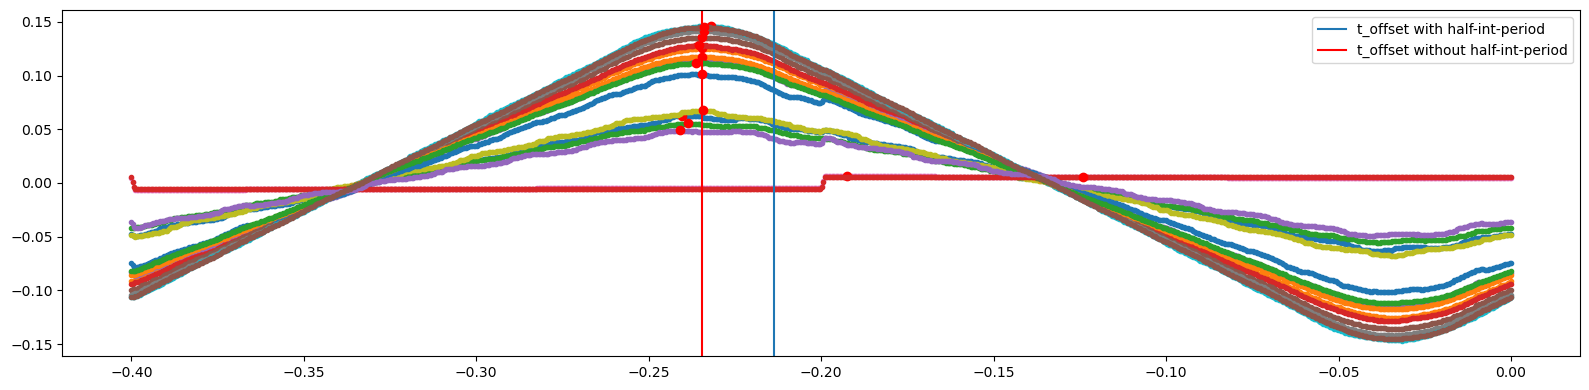

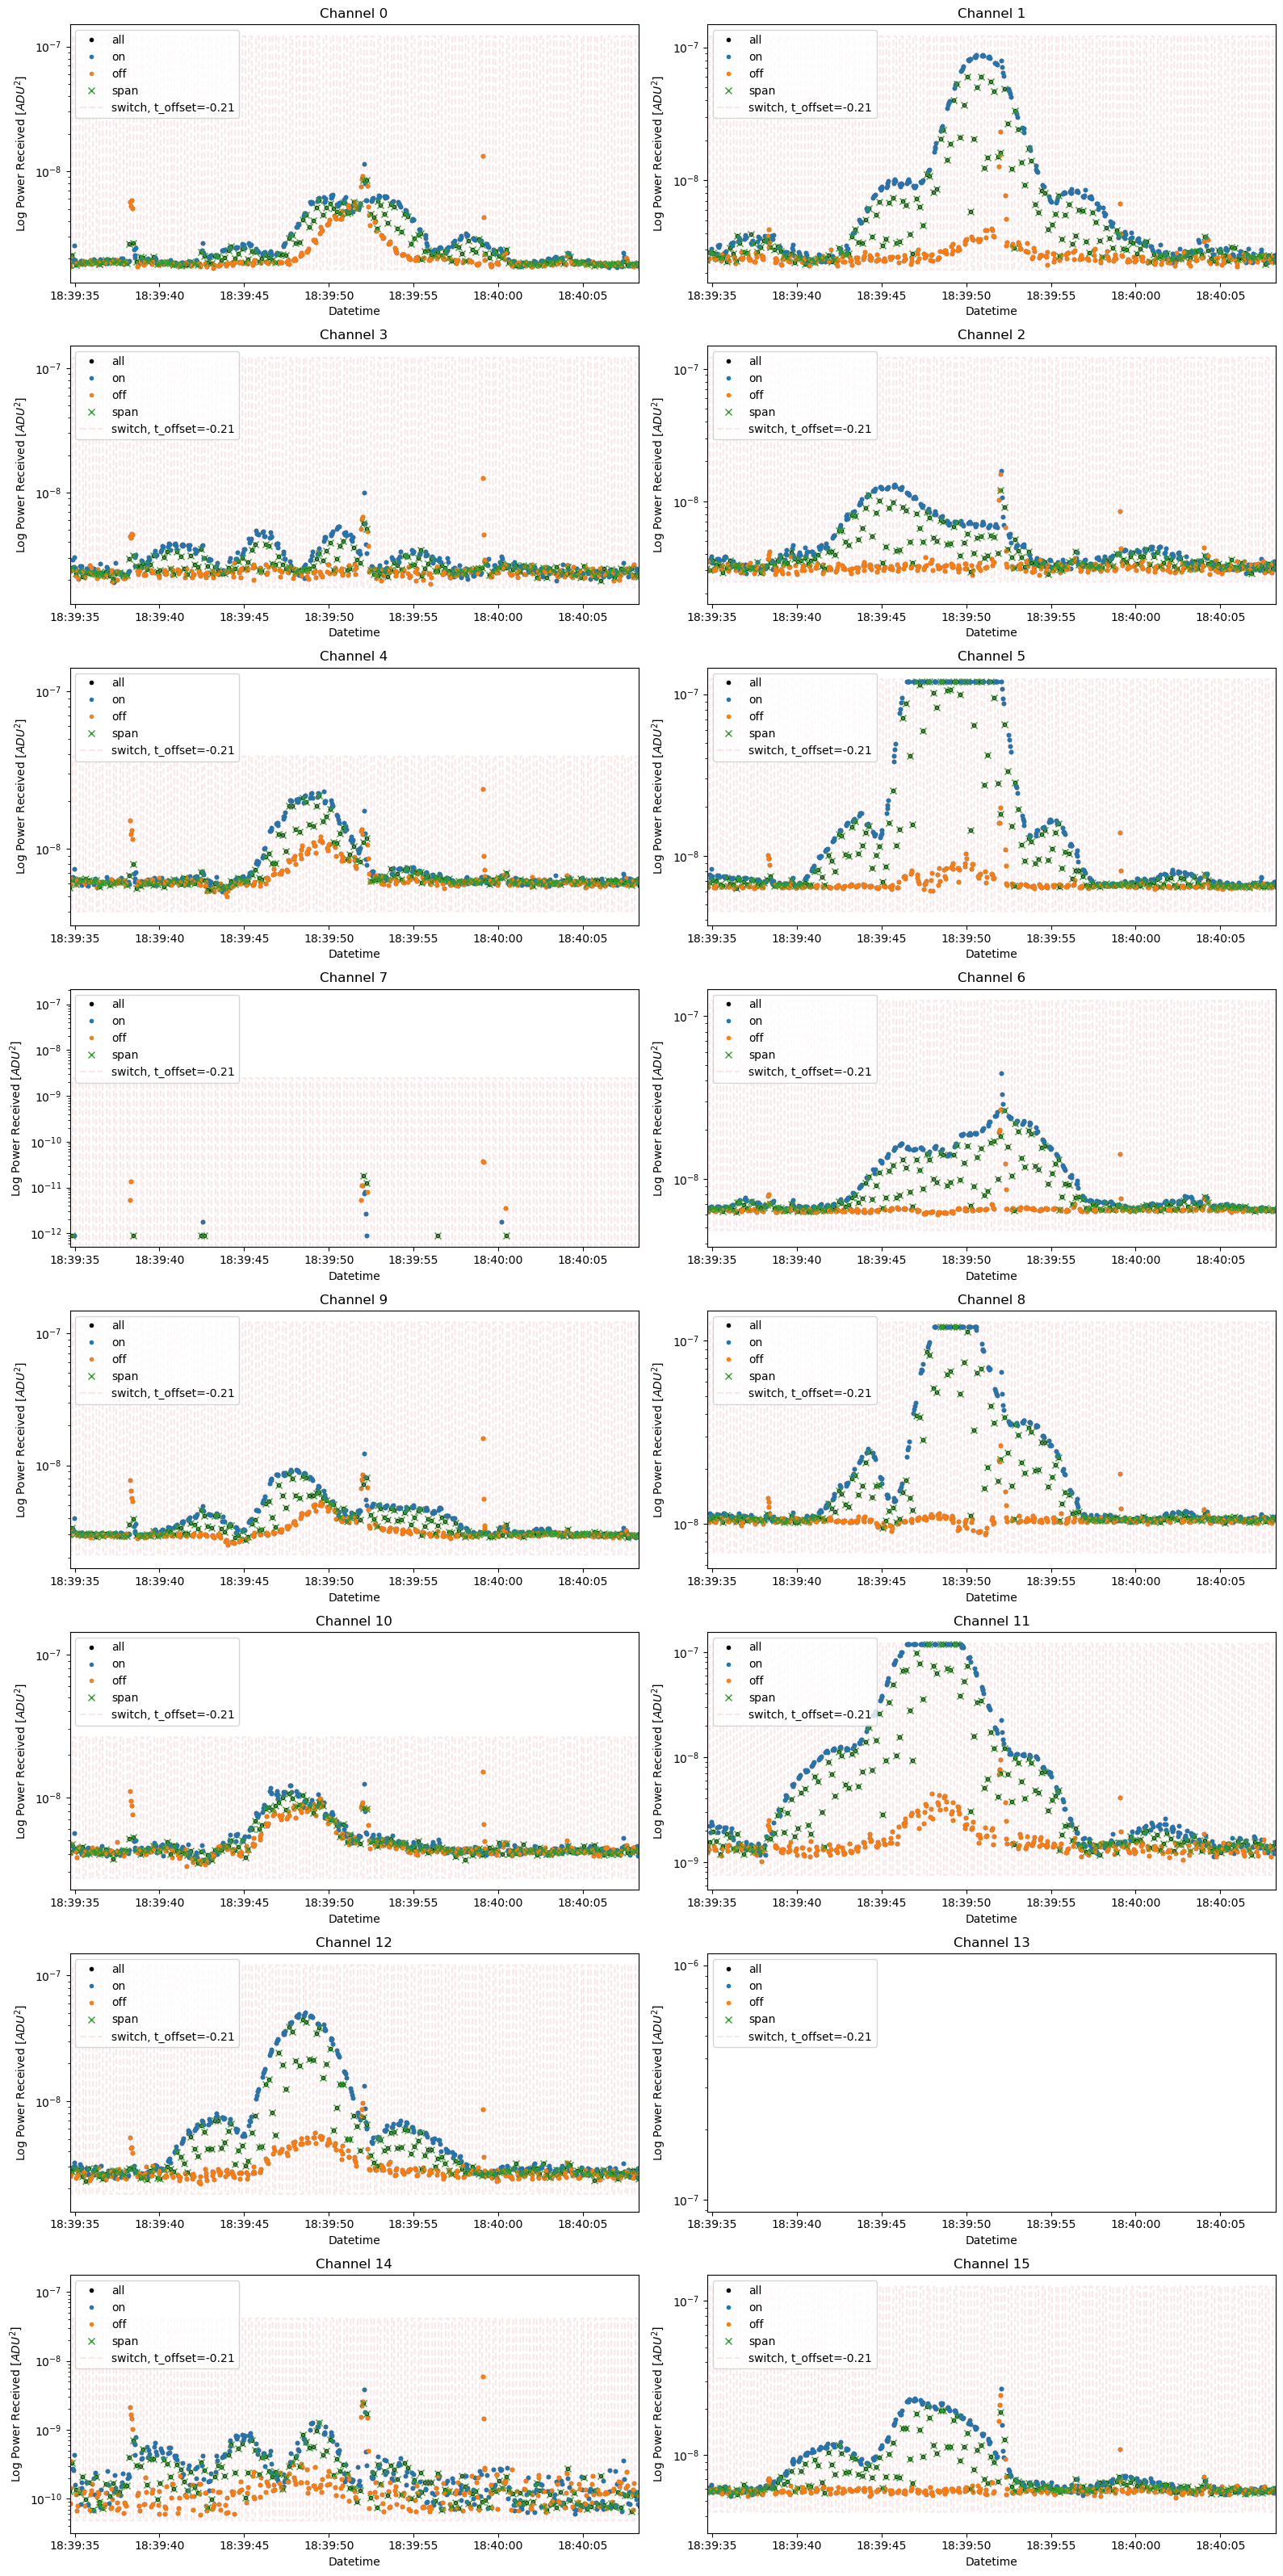

In [9]:
## OBJECTIVE 5A: concat Function: Extract_Source_Pulses

## Let's use the Extract_Source_Pulses function:
    # The Period and Dutycycle options are known beforehand, and given in microseconds.
    # The t_bounds option just determines the plot bounds, not the solving routine.
## Fortunately, these parameters are loaded from the config, so we don't have to wait for the solver to run.
    ## The returned t_delta_pulse parameter will be given in seconds.
    ## In the verification plot, we should see the following points plotted:
        # orange_o = inds_off  = times when the source is off
        # blue_o   = inds_on   = times when the source is on and broadcasting
        # green_x  = inds_span = times where the behavior changes during the integration period (omit always!)
    ## The print statements shows the list of indices that appear in more than one of on/off/span.
        ## If they are all empty lists [], then there is no overlap which is a good thing.
concattest0825.Extract_Source_Pulses(Period=0.4e6,Dutycycle=0.2e6,t_bounds=[14800,15600])

In [10]:
## OBJECTIVE 5B: concat Function: Perform_Background_Subtraction

## Let's do background subtraction: creates computed background (V_bg) and background-subtracted (V_bgsub) arrays:
    # window_size=5 - this is 1/2 the width of the 'index window' across which the background is averaged.
    # This function only works if the source was pulsed and Extract_Source_Pulses was used!
concattest0825.Perform_Background_Subtraction(window_size=5)

Calculating background spectra from indices where the noise source is off.


/home/erk26/anaconda3/lib/python3.7/site-packages/beamcals/concat.py:317: RuntimeWarning: Mean of empty slice
  self.V_bg[k,:,:]=np.nanmean(self.V[t_window,:,:],axis=0)


  --> Background subtraction completed using window_size = 5


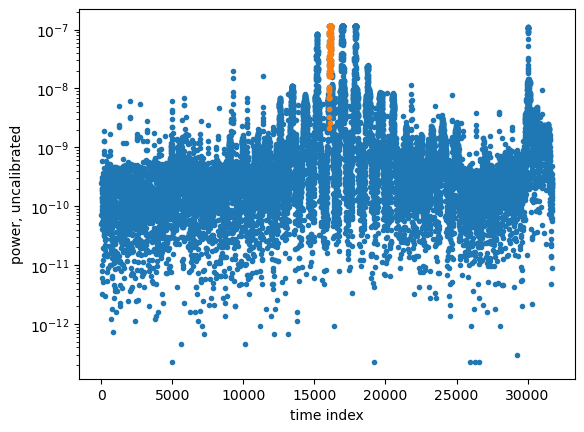

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: divide by zero encountered in log10
  if sys.path[0] == "":
/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log10
  if sys.path[0] == "":


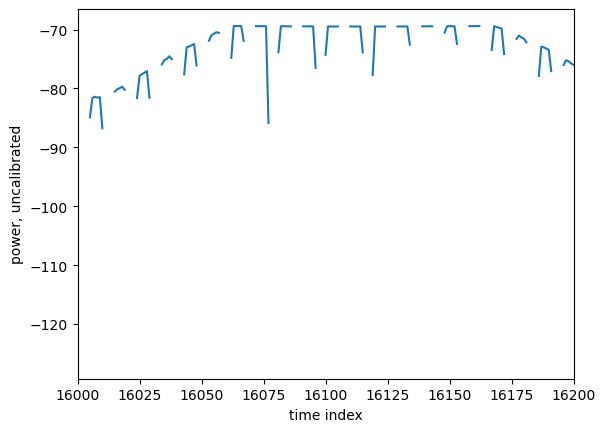

/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: divide by zero encountered in log10
/home/erk26/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in log10


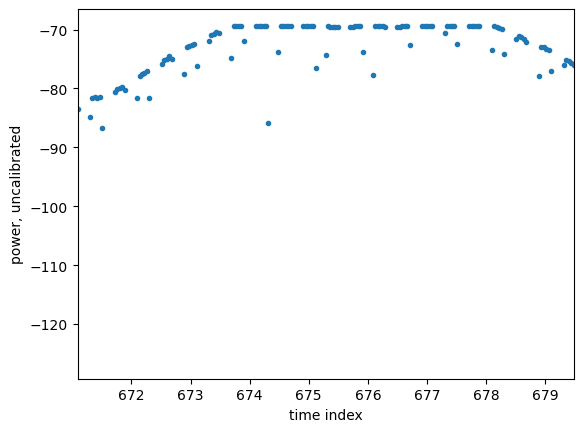

In [53]:
#note, array is structured like: concattest0825.V_bgsub[timeindex,frequencyindex,polarizationindex]
lb = 16000
ub = 16200

plot(concattest0825.V_bgsub[:,900,1], '.')
plot(np.arange(lb,ub), concattest0825.V_bgsub[:,900,1][lb:ub], '.')
xlabel('time index')
ylabel('power, uncalibrated')
semilogy()
show()

plot(10*np.log10(concattest0825.V_bgsub[:,900,1]))
xlabel('time index')
ylabel('power, uncalibrated')
xlim(lb,ub)
show()

plot(concattest0825.t_index*concattest0825.tstep, 10*np.log10(concattest0825.V_bgsub[:,900,1]), '.')
xlabel('time index')
ylabel('power, uncalibrated')
xlim(concattest0825.t_index[lb]*concattest0825.tstep,concattest0825.t_index[ub]*concattest0825.tstep)
show()

# October Flights

In [12]:
import numpy as np
from matplotlib.pyplot import *
import glob
import os
import datetime
from scipy.optimize import curve_fit
from scipy.optimize import leastsq
from scipy.optimize import least_squares
from random import sample
from astropy.time import Time
from matplotlib import colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import LogNorm
from matplotlib.ticker import MultipleLocator
import pytz
import bisect
import pygeodesy
from mpl_toolkits import mplot3d
import pandas as pd
import pickle

In [ ]:
def RotMat(ypr_arr):
    [a,b,c]=(np.pi/180.0)*ypr_arr
    RM=np.ndarray((3,3))
    RM[0,:]=[np.cos(a)*np.cos(b),np.cos(a)*np.sin(b)*np.sin(c)-np.sin(a)*np.cos(c),np.cos(a)*np.sin(b)*np.cos(c)+np.sin(a)*np.sin(c)]
    RM[1,:]=[np.sin(a)*np.cos(b),np.sin(a)*np.sin(b)*np.sin(c)+np.cos(a)*np.cos(c),np.sin(a)*np.sin(b)*np.cos(c)-np.cos(a)*np.sin(c)]
    RM[2,:]=[-1*np.sin(b),np.cos(b)*np.sin(c),np.cos(b)*np.cos(c)]
    return RM

def xyz_to_rpt(xyz):
    r_prime=np.sqrt(xyz[0]**2.0+xyz[1]**2.0+xyz[2]**2.0)
    phi_prime=np.arctan2(xyz[1],xyz[0])
    if phi_prime<0:
        phi_prime=phi_prime+(2.0*np.pi)
    theta_prime=np.arccos(xyz[2]/r_prime)
    rpt=[r_prime,phi_prime,theta_prime]
    return rpt

class Drone_Data_ublox2:
    def __init__(self,Drone_Directory,FLYTAG,site_class):
        self.FLYTAG=FLYTAG
        self.Drone_Directory=Drone_Directory
        ## Import variables from site-specific site_class object:
        self.name=site_class.name
        self.n_dishes=site_class.n_dishes
        self.n_channels=site_class.n_channels
        self.chmap=site_class.chmap
        self.origin=site_class.origin
        self.prime_origin=pygeodesy.EcefCartesian(latlonh0=self.origin[0],lon0=self.origin[1],height0=self.origin[2])
        self.dish_keystrings=site_class.keystrings
        self.dish_coords=site_class.coords
        self.dish_pointings=site_class.pointings
        self.dish_polarizations=site_class.polarizations 
        
        fileset_arr = glob.glob(Drone_Directory+FLYTAG)
        fileset_arr.sort()

        drone_data = pd.read_csv(fileset_arr[0],sep=",",header=1)
        for file in fileset_arr[1:]:
            drone_data1=pd.read_csv(file,sep=",",header=1)
            drone_data = pd.concat([drone_data, drone_data1])
        
        ## Assign Drone RTK Data to class variables:
        

        if "_processed" in FLYTAG:
            print("Initializing drone data via processed_csv routine: {}".format(FLYTAG))
            self.latitude=np.array(drone_data.Lat)
            self.longitude=np.array(drone_data.Lon)
            self.hmsl=np.array(drone_data.HMSL)
            self.altitude=np.array(drone_data.HMSL)[:]-self.origin[2]
            self.yaw = np.array(drone_data.yaw)
            try:
                self.t_arr_timestamp=np.array(drone_data.timestamp)
            except AttributeError:
                self.t_arr_timestamp=np.array(drone_data.datetimestamp)
            self.t_index=np.arange(len(self.t_arr_timestamp))
            #self.t_arr_datetime=np.array([np.datetime64(self.t_arr_timestamp[m]).astype(datetime.datetime).replace(tzinfo=pytz.UTC) for m in range(self.t_index.shape[0])])
            self.t_arr_datetime=np.array(drone_data.assign(UTC=pandas.to_datetime(drone_data.UTC)).UTC)
            #self.t_arr_datetime=np.array([np.datetime64(self.t_arr_timestamp[m]).astype(datetime.datetime).replace(tzinfo=pytz.UTC) for m in range(self.t_index.shape[0])])
        else:
#             print("Initializing drone data via datcon_csv routine: {}".format(FLYTAG))
            self.latitude=np.array(drone_data["Lat"])
            self.longitude=np.array(drone_data["Lon"])
            self.yaw = np.array(drone_data["yaw"])
            self.hmsl=np.array(drone_data["HMSL"])
            self.t_arr_datetime=np.array(pd.to_datetime(drone_data["UTC"]))
            self.t_index=np.arange(len(self.t_arr_datetime))
#             self.t_arr_datetime=np.array(interp_time(drone_data)["UTC"],dtype='object')
            self.altitude=np.array(drone_data["HMSL"])[:]-self.origin[2]
        ## Define coordinate systems we will eventually want to use:
        print("generating llh, geocentric cartesian, local cartesian, and local spherical coordinates.")
        self.coords_llh=np.NAN*np.ones((self.t_index.shape[0],3))     ## Lat,Lon,hmsl from drone/RTK
        self.coords_xyz_GC=np.NAN*np.ones((self.t_index.shape[0],3))  ## x,y,z in meters in geocentric cartesian
        self.coords_xyz_LC=np.NAN*np.ones((self.t_index.shape[0],3))  ## x,y,z cartesian wrt a chosen origin (x=E,y=N,z=up)
        self.coords_rpt=np.NAN*np.ones((self.t_index.shape[0],3))     ## r,theta,phi wrt a chosen origin
        ## Populate and calculate these coordinate systems:
        for i in self.t_index[np.where(np.isnan(self.latitude)==False)]:
            try:
                ## Create LatLon point for each recorded drone position:
                p_t=pygeodesy.ellipsoidalNvector.LatLon(self.latitude[i],lon=self.longitude[i],height=self.hmsl[i])
            except: pass
#             except RangeError:
#                 print("poo")
            ## Assign llh, xyz, xyz_prime, rpt_prime coordinates, pointwise:
            self.coords_llh[i]=p_t.to3llh()
            self.coords_xyz_GC[i]=p_t.to3xyz()
            self.coords_xyz_LC[i]=self.prime_origin.forward(p_t).toVector()        
            r_prime=np.sqrt(self.coords_xyz_LC[i,0]**2.0+self.coords_xyz_LC[i,1]**2.0+self.coords_xyz_LC[i,2]**2.0)      
            phi_prime=np.arctan2(self.coords_xyz_LC[i,1],self.coords_xyz_LC[i,0])
            if phi_prime<0:
                phi_prime=phi_prime+(2.0*np.pi)
            theta_prime=np.arccos(self.coords_xyz_LC[i,2]/r_prime)
            self.coords_rpt[i]=[r_prime,phi_prime,theta_prime]
                
        print("generating dish and receiver line of sight coordinates.")
        ## Calculate per-dish polar coordinates for drone/receiver in each other's beams as fxn of time:
        self.rpt_r_per_dish=np.zeros((len(self.dish_keystrings),len(self.t_index),3)) # drone posn wrt receiver
        self.rpt_t_per_dish=np.zeros((len(self.dish_keystrings),len(self.t_index),3)) # receiver posn wrt drone
        for i in range(len(self.dish_keystrings)):
            ## Receiver RPT after TRANS and ROT: (from receiver N to Drone in Receiver Cartesian "RC" coords)
            drone_xyz_RC=self.coords_xyz_LC-self.dish_coords[i] # translate LC to receiver i position
            ## Rotate coord system by dish pointing with rotation matrix (constant in t):
            rec_pointing_rot=RotMat(np.array([xyz_to_rpt(self.dish_pointings[i])[2],0.0,xyz_to_rpt(self.dish_pointings[i])[1]]))
            ## Populate receiver position wrt drone:
            self.rpt_r_per_dish[i,:,:]=np.array([xyz_to_rpt(rec_pointing_rot@drone_xyz_RC[k]) for k in range(len(self.coords_xyz_LC))])
            ## Transmitter RPT after TRANS and ROT: (from Drone to receiver N in Drone coords)
            rec_xyz_LC=-1.0*(self.coords_xyz_LC)+self.dish_coords[i] # in LC relative to drone, without rotation (yet)
            ## Rotate coord system by drone pointing with rotation matrix (varies with yaw,pitch,roll as fxns of t):
            ypr=np.ndarray((len(self.t_index),3))
            self.rpt_t_per_dish[i,:,:]=np.array([xyz_to_rpt(RotMat(ypr[m,:])@(RotMat(np.array([90.0,0.0,180.0]))@rec_xyz_LC[m])) for m in range(len(self.coords_xyz_LC))])
 